In [2]:
pip install torch torchvision transformers matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import numpy as np

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [5]:
def get_text_features(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = text_model(**inputs).last_hidden_state
    return text_features.mean(dim=1)

In [6]:
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim, image_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_dim + noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, image_size * image_size * 3),
            nn.Tanh(),  # Output range [-1, 1]
        )
        self.image_size = image_size

    def forward(self, text_features, noise):
        x = torch.cat((text_features, noise), dim=1)
        x = self.fc(x)
        return x.view(-1, 3, self.image_size, self.image_size)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, image_size, text_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_size * image_size * 3 + text_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        self.image_size = image_size

    def forward(self, image, text_features):
        image_flat = image.view(image.size(0), -1)  # Flatten image
        x = torch.cat((image_flat, text_features), dim=1)
        return self.fc(x)

In [8]:
text_dim = 512  # CLIP embedding size
noise_dim = 100
image_size = 64
lr = 0.0002
num_epochs = 1000
batch_size = 16

In [9]:
generator = Generator(text_dim, noise_dim, image_size).to(device)
discriminator = Discriminator(image_size, text_dim).to(device)

In [11]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop (simplified)
text_input = "A beautiful painting of a sunset over a mountain range."
text_features = get_text_features(text_input).to(device)

real_label = 1.0
fake_label = 0.0

In [12]:
for epoch in range(num_epochs):
    # 1. Train Discriminator
    noise = torch.randn(batch_size, noise_dim).to(device)
    fake_images = generator(text_features.expand(batch_size, -1), noise)
    real_images = torch.randn(batch_size, 3, image_size, image_size).to(device)  # Random placeholder

    real_labels = torch.full((batch_size, 1), real_label, device=device)
    fake_labels = torch.full((batch_size, 1), fake_label, device=device)

    # Discriminator loss
    optimizer_D.zero_grad()
    output_real = discriminator(real_images, text_features.expand(batch_size, -1))
    loss_real = criterion(output_real, real_labels)

    output_fake = discriminator(fake_images.detach(), text_features.expand(batch_size, -1))
    loss_fake = criterion(output_fake, fake_labels)

    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    # 2. Train Generator
    optimizer_G.zero_grad()
    output_fake = discriminator(fake_images, text_features.expand(batch_size, -1))
    loss_G = criterion(output_fake, real_labels)  # Generator tries to fool the discriminator
    loss_G.backward()
    optimizer_G.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

Epoch [0/1000], Loss D: 1.2960221767425537, Loss G: 0.9585853815078735
Epoch [100/1000], Loss D: 0.8594541549682617, Loss G: 1.0323306322097778
Epoch [200/1000], Loss D: 1.298841118812561, Loss G: 0.9604580998420715
Epoch [300/1000], Loss D: 1.5094678401947021, Loss G: 0.6430277824401855
Epoch [400/1000], Loss D: 1.5086705684661865, Loss G: 0.5448118448257446
Epoch [500/1000], Loss D: 1.991424560546875, Loss G: 0.8245912790298462
Epoch [600/1000], Loss D: 1.5214226245880127, Loss G: 0.6906661987304688
Epoch [700/1000], Loss D: 1.374251365661621, Loss G: 0.74188631772995
Epoch [800/1000], Loss D: 1.4003643989562988, Loss G: 0.6958644986152649
Epoch [900/1000], Loss D: 1.6226277351379395, Loss G: 0.9418609738349915


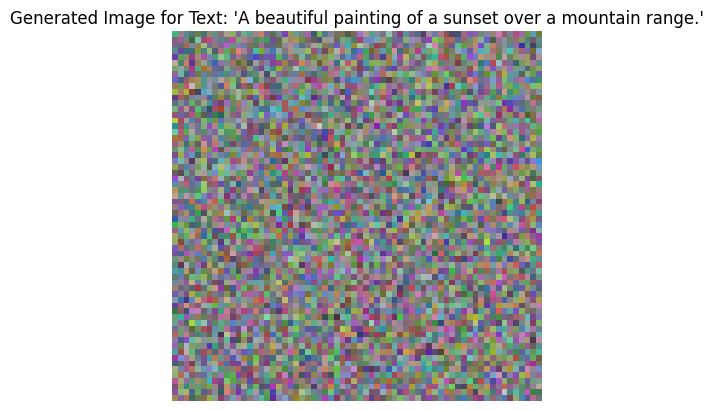

In [13]:
# 4. Generate and visualize an image
with torch.no_grad():
    noise = torch.randn(1, noise_dim).to(device)
    generated_image = generator(text_features, noise).cpu().squeeze().permute(1, 2, 0).numpy()
    generated_image = (generated_image + 1) / 2  # Rescale to [0, 1]

plt.imshow(generated_image)
plt.axis("off")
plt.title(f"Generated Image for Text: '{text_input}'")
plt.show()